# includes

In [1]:
from PIL import Image
import os
import numpy as np 
import pandas as pd 
import torchvision.transforms as transforms
from torchvision.models import resnet50
import random
import torch
import matplotlib.pyplot as plt 
import cv2
from scipy.signal import savgol_filter
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from skimage import  exposure



# classes and fonctions

In [12]:


def extract_number(folder_name):
    return int(folder_name.split('.')[0])

def extract_number_files(folder_name):
    return int(folder_name.split('EX')[1].split('.')[0])

def get_images_path_list(input_folder) :
    path_list = []
    parent_folder_path = input_folder
    folders = [f for f in os.listdir(parent_folder_path) if os.path.isdir(os.path.join(parent_folder_path, f))]
    sorted_folders = sorted(folders, key=extract_number)

    for dirs in sorted_folders:
        files = os.listdir(parent_folder_path+dirs)
        file_names = [f for f in files if os.path.isfile(os.path.join(parent_folder_path+dirs, f))]
        file_names = sorted(file_names, key=extract_number_files)
        # print(dirs)
        for filename in file_names:
            image_path = os.path.join(parent_folder_path+dirs, filename)
            # print(image_path)
            path_list.append(image_path)

    return path_list


def apply_pca(data,name, n_components=2):

    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data)

    pca_columns = [f'PC_{name}_{i+1}' for i in range(principal_components.shape[1])] # for i in range(n_components)

    return pd.DataFrame(data=principal_components, columns=pca_columns)


def plot_hog_example(image):
    fd, hog_image = hog(image, orientations=8 , pixels_per_cell=(16, 16) ,cells_per_block=(1, 1),
                    visualize=True, channel_axis=-1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('Input image')

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    ax2.axis('off')
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    plt.show()


def plot_five_ex_clusters(clusters , images):

    # 5. Filter out noise and small clusters
    unique_clusters = np.unique(clusters)
    filtered_clusters = [cluster for cluster in unique_clusters if cluster != -1]

    # 6. Select representative images from each cluster
    n_examples = 5
    example_images = {cluster: [] for cluster in filtered_clusters}

    for cluster in filtered_clusters:
        cluster_indices = np.where(clusters == cluster)[0]
        if len(cluster_indices) > 10:  # Minimum cluster size threshold
            selected_indices = random.sample(list(cluster_indices), min(n_examples, len(cluster_indices)))
            example_images[cluster] = selected_indices

    # 7. Plot example images from each cluster
    plt.figure(figsize=(15, len(example_images) * 3))
    for i, (cluster, indices) in enumerate(example_images.items()):
        for j, index in enumerate(indices):
            plt.subplot(len(example_images), n_examples, i * n_examples + j + 1)
            plt.imshow(images[index])
            plt.axis('off')
            if j == 0:
                plt.title(f'Cluster {cluster}')
    plt.tight_layout()
    plt.show()

def Calculate_avg_leaf_to_background_ratio(binary_images):

    black_pixels = np.sum(binary_images == 0)
    white_pixels = np.sum(binary_images == 255)
    average_leaf_to_background_ratio = white_pixels /  black_pixels if black_pixels != 0 else float('nan')
    return average_leaf_to_background_ratio

def find_Length_and_width(image_array):
    y_start = 0
    x_start = 0
    y_end , x_end = image_array.shape
    
    # find y_start , y_end
    for i in range(image_array.shape[0]): 
        if (image_array[i].sum() > 0) and (y_start == 0):
            y_start = i

        if (image_array[-i].sum()>0) and (y_end == image_array.shape[0]):
            y_end = image_array.shape[0] - i
    # find x_start , x_end
    for j in range(image_array.shape[1]): 
        if (image_array[: , j].sum() > 0) and (x_start == 0):
            x_start = j
        if (image_array[: , -j].sum() > 0) and (x_end == image_array.shape[1]):
            x_end = image_array.shape[1] - j

    return y_start , y_end , x_start , x_end

    
class pythorch_images():
    def __init__(self) -> None:
        self.model = resnet50(pretrained=True)
        self.images = []
        self.features = np.array([])

    def extract_features_cnn(self):
        # model = 
        model = self.model.eval()  # Set to evaluation mode
        # Define the transformation for preprocessing images
        preprocess = transforms.Compose([
            # transforms.Resize((192,144)),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # Extract features from the images
        features = []
        for img in self.images:
            img_tensor = preprocess(img).unsqueeze(0)
            with torch.no_grad():
                feature = model(img_tensor).squeeze().numpy()
            features.append(feature)

        # return np.array(features)
        self.features = np.array(features)

    def load_images(self ,image_dir : str, target_size: tuple =(192,144) ) ->list:
        images = []
        images_path = get_images_path_list(image_dir)
        for img_path in images_path:
            img = Image.open(img_path).convert('RGB')
            img = img.resize(target_size)
            images.append(img)

        self.images = images
        
class cv2_images():
    def __init__(self) -> None:
        self.rgb_images = []
        self.gray_images = []
        self.binary_images = []
        self.contours_images=[]
        self.list_distances=[]
        self.list_images_hog= np.array([])

    def get_images_inf(self , input_folder):
        path_list = get_images_path_list(input_folder )
        for image_path in path_list:
                
            image = cv2.imread(image_path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            blurred = cv2.GaussianBlur(gray, (5, 5), 0)
            _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

            contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            cnt = tuple()
            for i in range(len(contours)):
                if len(cnt) < len(contours[i]):
                    cnt = contours[i]

            self.rgb_images.append(image)
            self.gray_images.append(gray)
            self.binary_images.append(thresholded)
            self.contours_images.append(cnt)

    def Calculate_distance_each_contour_from_centroid(self, savgol_filter_:bool=False , window_length=50 , polyorder=2):
        for cnt in self.contours_images:
            M = cv2.moments(cnt)
            centroid_x = int(M['m10'] / M['m00'])
            centroid_y = int(M['m01'] / M['m00'])

            # Calculate distance of each contour point from the centroid
            distances = []
            for point in cnt:
                x, y = point[0]
                distance = np.sqrt((x - centroid_x) ** 2 + (y - centroid_y) ** 2)
                distances.append(distance)

            # Convert to a numpy array and normalize
            distances = np.array(distances)
            distances = distances / np.max(distances)
            if savgol_filter_:
                smoothed_signal = savgol_filter(distances, window_length=window_length, polyorder=polyorder)
                self.list_distances.append(list(smoothed_signal))
            else:
                self.list_distances.append(list(distances))
        # return distances
    
    def get_pictures_hog(self):
        hog_list = []
        for image in self.rgb_images:
            fd , hog_image = hog(image, orientations=8 , pixels_per_cell=(16, 16) ,cells_per_block=(1, 1),visualize=True, channel_axis=-1)
            hog_list.append(fd)

        self.list_images_hog = np.vstack(hog_list)

    


# working with cv2 and leaves_final dir

In [ ]:
cv_2 = cv2_images()
cv_2.get_images_inf('leaves_final/')

## cluster and apply PCA on pictures hog and  calculate hogs_mean

In [74]:
cv_2.get_pictures_hog()
cv_2.list_images_hog.shape

(340, 21600)

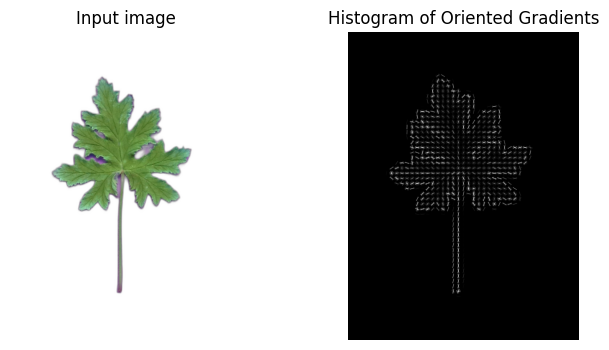

In [8]:
plot_hog_example(cv_2.rgb_images[330])

### kmean cluster

In [91]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(cv_2.list_images_hog)
clusters

c:\Users\akgh1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2, 2, 2,
       0, 1, 1, 0, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 2, 0, 1,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2, 2, 1, 0, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0,

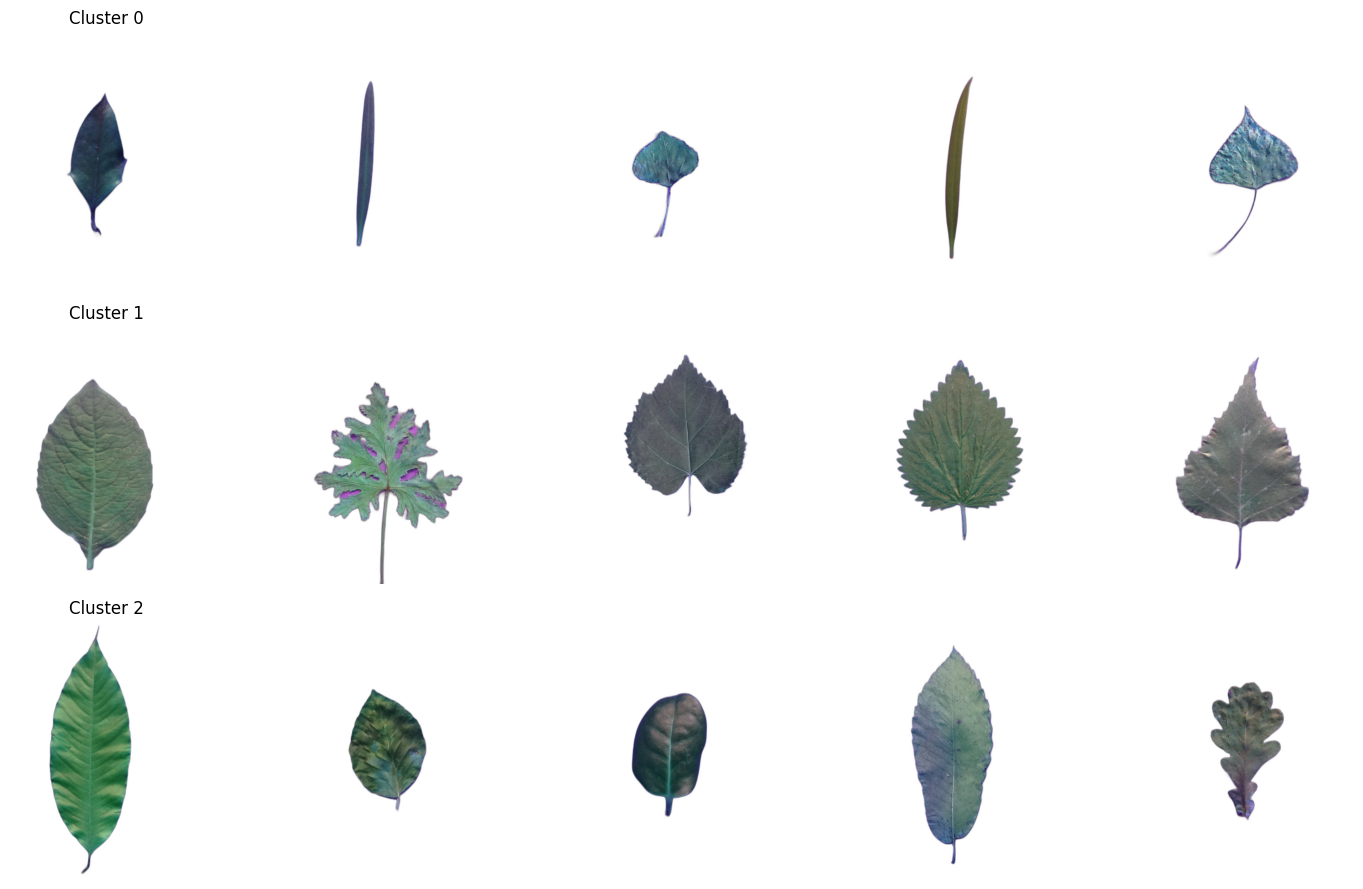

In [92]:
plot_five_ex_clusters(clusters , cv_2.rgb_images)

### apply PCA on pictures hog

In [95]:
pca_df = apply_pca(cv_2.list_images_hog , 'pictures_hog' , n_components=2)
pca_df

,PC_pictures_hog_1,PC_pictures_hog_2
0,-0.594119,11.957644
1,-5.462840,6.630552
2,-8.045611,3.459396
3,-6.813601,4.748391
4,-9.762819,2.426338
...,...,...
335,12.018704,2.145811
336,14.362893,3.853692
337,7.886197,1.708210
338,0.592375,-5.476900


In [101]:
# calculate mean of each hog
list_hog = []
for hog in cv_2.list_images_hog:
    list_hog.append(hog.mean())

In [103]:
new_df = pd.read_csv('new_leaves.csv').drop(['Unnamed: 0'],axis=1)
new_df['hog_Kmeans_2_cluster']= clusters
new_df['mean_hog'] = list_hog
new_df = pd.concat([new_df , pca_df ], axis=1)
new_df

,A,B,C,D,E,F,G,H,I,J,...,cnn_Kmeans_8_cluster,hog_Kmeans_2_cluster,cnn_Kmeans_4_cluster,cluster_on_distances,2_cluster_hog_plot,PC_dectances_from_centroid_1,PC_dectances_from_centroid_2,PC_plot_hog_1,PC_pictures_hog_1,PC_pictures_hog_2
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.835920,0.004657,0.003947,...,5,1,1,1,0,-1.140975,-3.884069,-3.874641,-0.594119,11.957644
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,...,0,1,0,1,0,-6.435096,0.550471,-3.054783,-5.462840,6.630552
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,...,0,1,0,1,0,-7.907891,4.008734,-2.066479,-8.045611,3.459396
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,...,0,1,0,1,0,-6.613881,0.746459,0.496433,-6.813601,4.748391
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,...,0,1,0,1,0,-7.859157,4.059017,-4.115402,-9.762819,2.426338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,36,6,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,...,2,0,3,0,1,11.588817,9.259357,6.976740,12.018704,2.145811
336,36,7,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,...,2,0,3,0,1,12.977147,9.204629,6.562909,14.362893,3.853692
337,36,8,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,...,2,0,3,0,1,5.666209,6.460358,2.763158,7.886197,1.708210
338,36,9,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,...,2,1,3,0,1,9.511234,5.380538,4.712902,0.592375,-5.476900


In [104]:
new_df.to_csv('new_leaves.csv')

## cluster and apply PCA on dectances

In [72]:
cv_2.Calculate_distance_each_contour_from_centroid()
len(cv_2.list_distances)

340

In [45]:
# find max len destances 
max_len=0
for destance in cv_2.list_distances: 
    if len(destance)> max_len:
        max_len = len(destance)

# convert all distances to the same shape (Fill smaller lists with zero)
padded_list = [sublist + [0] * (max_len - len(sublist)) for sublist in cv_2.list_distances]
padded_list = np.array(padded_list)
padded_list.shape

(340, 1984)

### kmean cluster

In [50]:
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(padded_list)
clusters

c:\Users\akgh1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([6, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 6, 2, 2, 2, 1,
       4, 2, 1, 6, 4, 2, 6, 2, 1, 6, 1, 2, 1, 6, 2, 2, 2, 1, 1, 1, 1, 4,
       4, 4, 1, 4, 4, 1, 4, 4, 6, 6, 4, 1, 1, 4, 4, 0, 1, 6, 4, 6, 6, 1,
       1, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 6, 3, 1, 1, 1,
       0, 4, 4, 6, 1, 2, 1, 3, 3, 1, 4, 3, 3, 6, 1, 1, 3, 1, 1, 3, 4, 3,
       3, 3, 4, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 4, 1, 4, 1, 1, 6, 2, 3,
       4, 4, 4, 1, 6, 6, 6, 0, 6, 1, 2, 1, 6, 6, 6, 4, 6, 1, 4, 4, 1, 6,
       4, 2, 1, 1, 1, 4, 1, 3, 5, 5, 5, 1, 3, 5, 3, 5, 5, 2, 2, 2, 2, 1,
       6, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 6, 2, 2, 0, 6, 2, 0, 6, 2, 2, 6,
       2, 1, 2, 0, 6, 6, 6, 2, 0, 4, 4, 1, 4, 1, 3, 1, 6, 3, 2, 2, 2, 2,
       2, 2, 6, 0, 6, 2, 6, 2, 2, 2, 2, 2, 2, 2, 6, 2, 6, 6, 0, 4, 6, 4,
       6, 4, 4, 4, 6, 4, 1, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 3, 1, 3, 1, 1, 6, 3, 1, 4, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0,
       2, 2, 6, 2, 2, 2, 2, 2, 2, 0, 0, 6, 1, 6, 0,

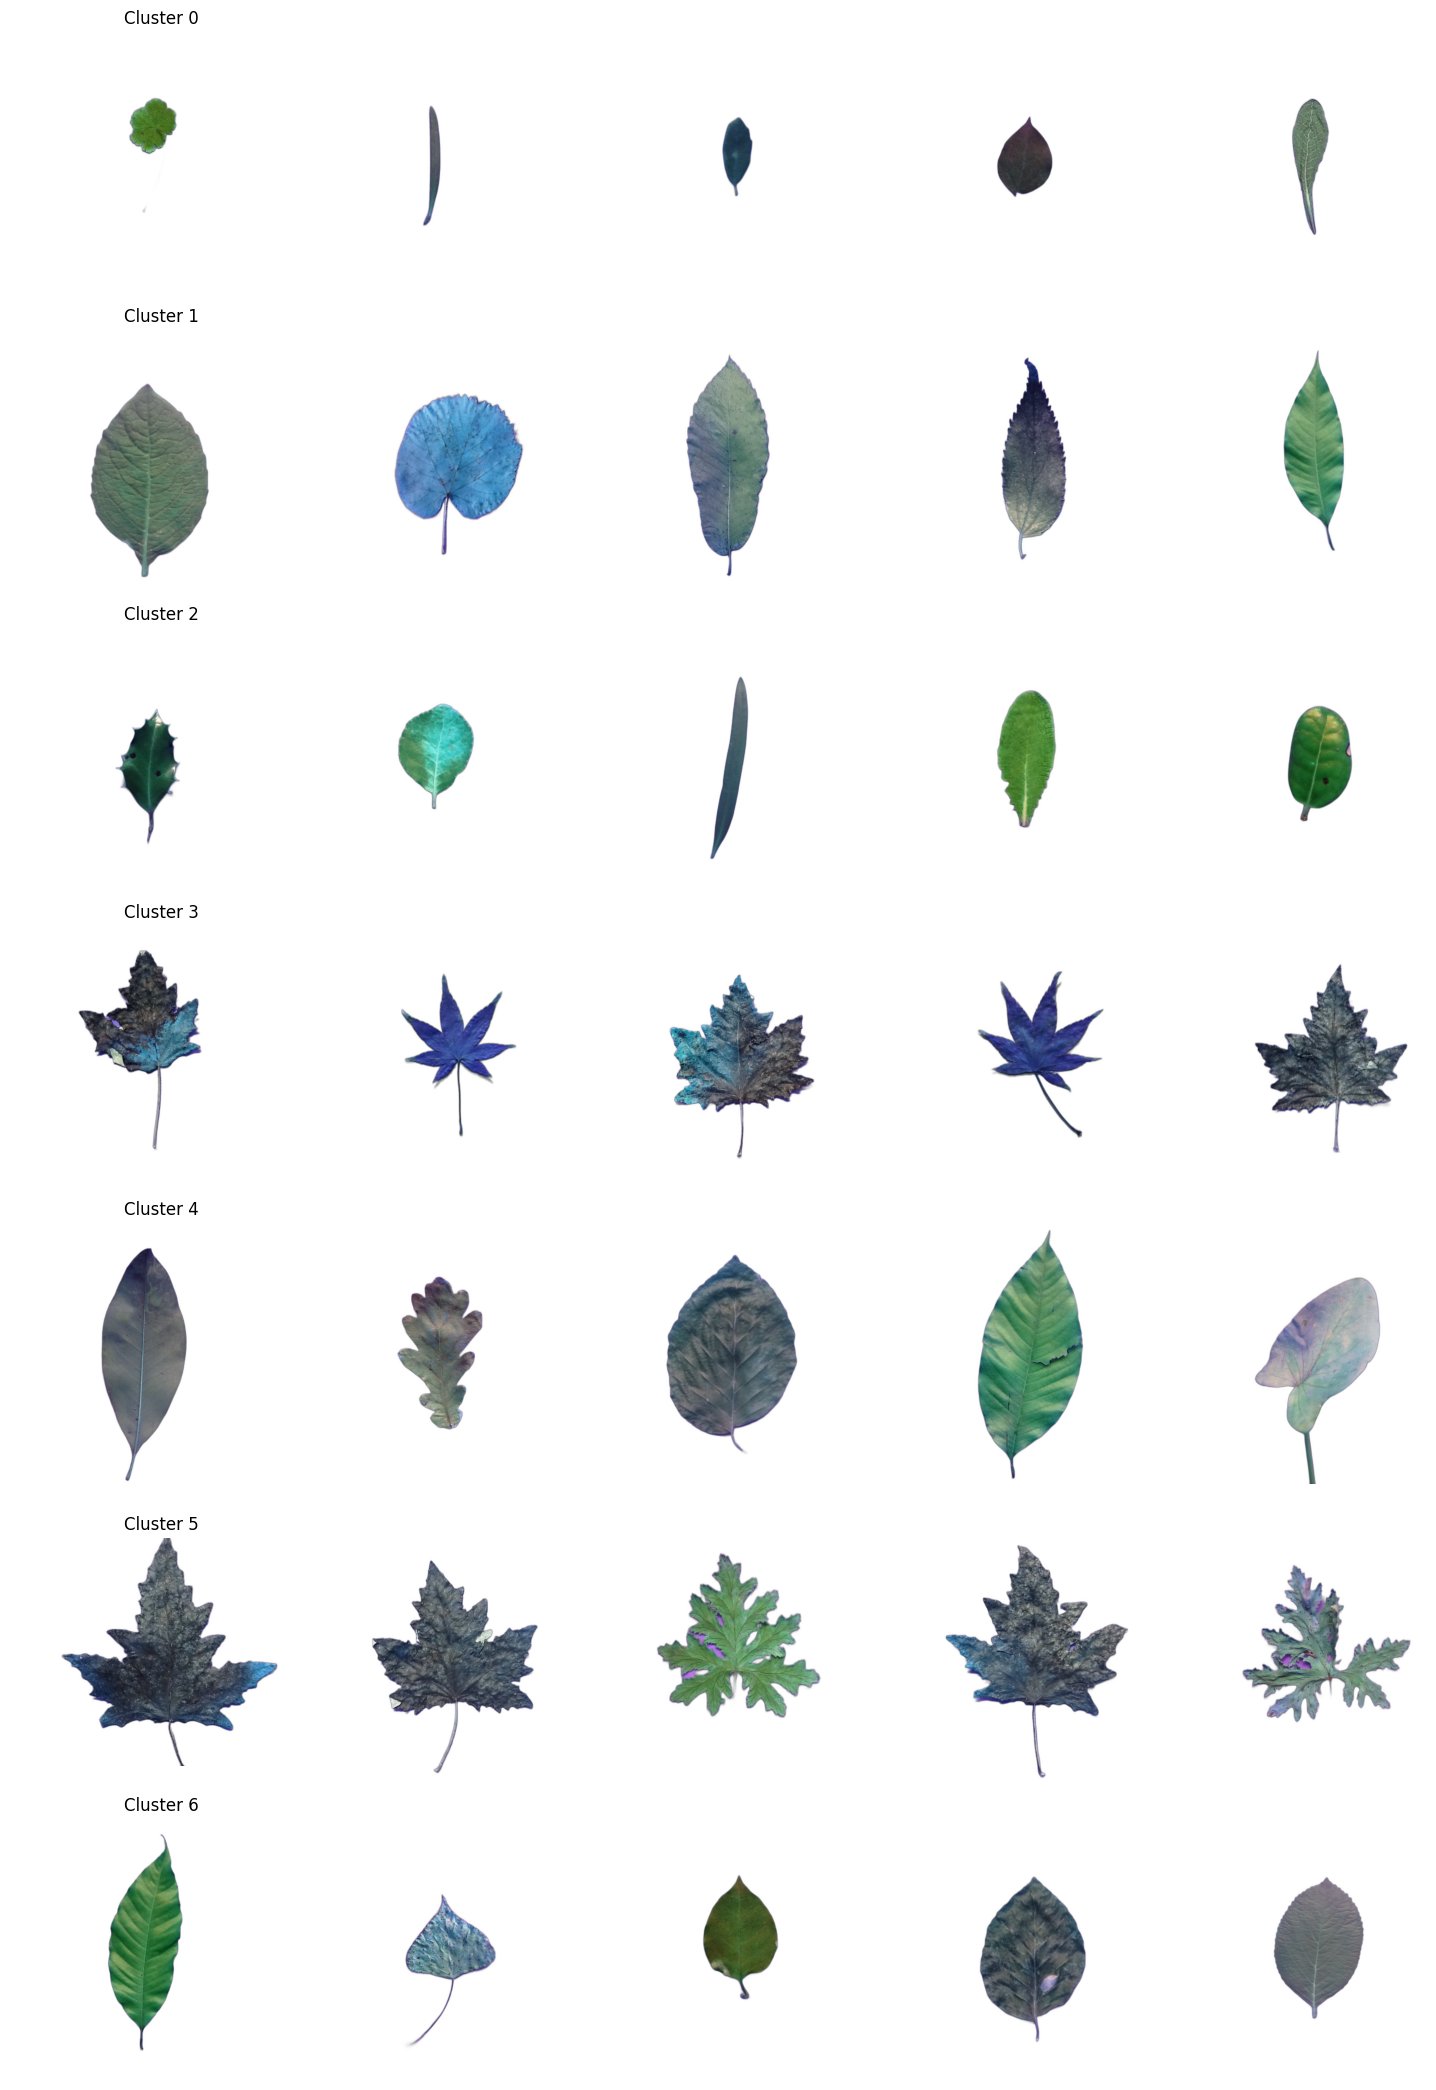

In [51]:
plot_five_ex_clusters(clusters , cv_2.rgb_images)

### apply PCA

In [56]:
pca_df = apply_pca(padded_list , "dectances_from_centroid" , n_components=2)
pca_df

,PC_dectances_from_centroid_1,PC_dectances_from_centroid_2
0,-1.140975,-3.884069
1,-6.435096,0.550471
2,-7.907891,4.008734
3,-6.613881,0.746459
4,-7.859157,4.059017
...,...,...
335,11.588817,9.259357
336,12.977147,9.204629
337,5.666209,6.460358
338,9.511234,5.380538


In [62]:
new_df = pd.read_csv('new_leaves.csv').drop(['Unnamed: 0'],axis=1)
new_df['cluster_on_distances']= clusters
new_df = pd.concat([new_df , pca_df], axis=1)
new_df

,A,B,C,D,E,F,G,H,I,J,...,avg_leaf_to_background_ratio,num_petals_of_leaves,cnn_Kmeans_8_cluster,hog_Kmeans_2_cluster,cnn_Kmeans_4_cluster,cluster_on_distances,2_cluster_hog_plot,PC_plot_hog_1,PC_dectances_from_centroid_1,PC_dectances_from_centroid_2
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.835920,0.004657,0.003947,...,2.244901,2,5,1,1,1,0,-9.417908,-1.140975,-3.884069
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,...,2.066886,2,0,1,0,1,0,-7.517348,-6.435096,0.550471
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,...,1.882448,3,0,1,0,1,0,-9.698732,-7.907891,4.008734
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,...,1.938800,2,0,1,0,1,0,-6.014785,-6.613881,0.746459
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,...,1.946505,2,0,1,0,1,0,-10.699137,-7.859157,4.059017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,36,6,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,...,0.956037,11,2,0,3,0,1,40.513253,11.588817,9.259357
336,36,7,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,...,1.088619,16,2,0,3,0,1,55.348625,12.977147,9.204629
337,36,8,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,...,0.501203,13,2,0,3,0,1,2.942721,5.666209,6.460358
338,36,9,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,...,0.406573,7,2,1,3,0,1,24.717741,9.511234,5.380538


In [64]:
new_df.to_csv('new_leaves.csv')

# working with cv2 for  (disentces_plot dir)

In [ ]:
c_v2 = cv2_images() # creat an object
c_v2.get_images_inf('disentces_plot/') # get images and there informations

## cluster and apply PCA on plots hog

### kmeans cluster

In [25]:
c_v2.get_pictures_hog() # get pictures histogram of oriented gradients
c_v2.list_images_hog.shape

(340, 9600)

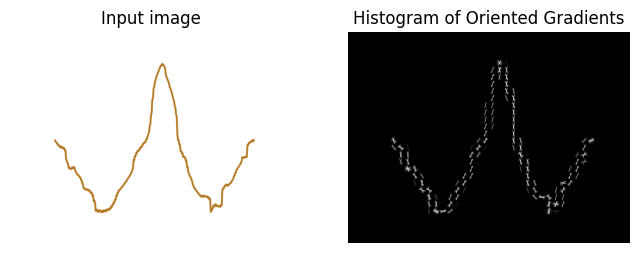

In [11]:
plot_hog_example(c_v2.rgb_images[2])

In [26]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(c_v2.list_images_hog)
clusters

c:\Users\akgh1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

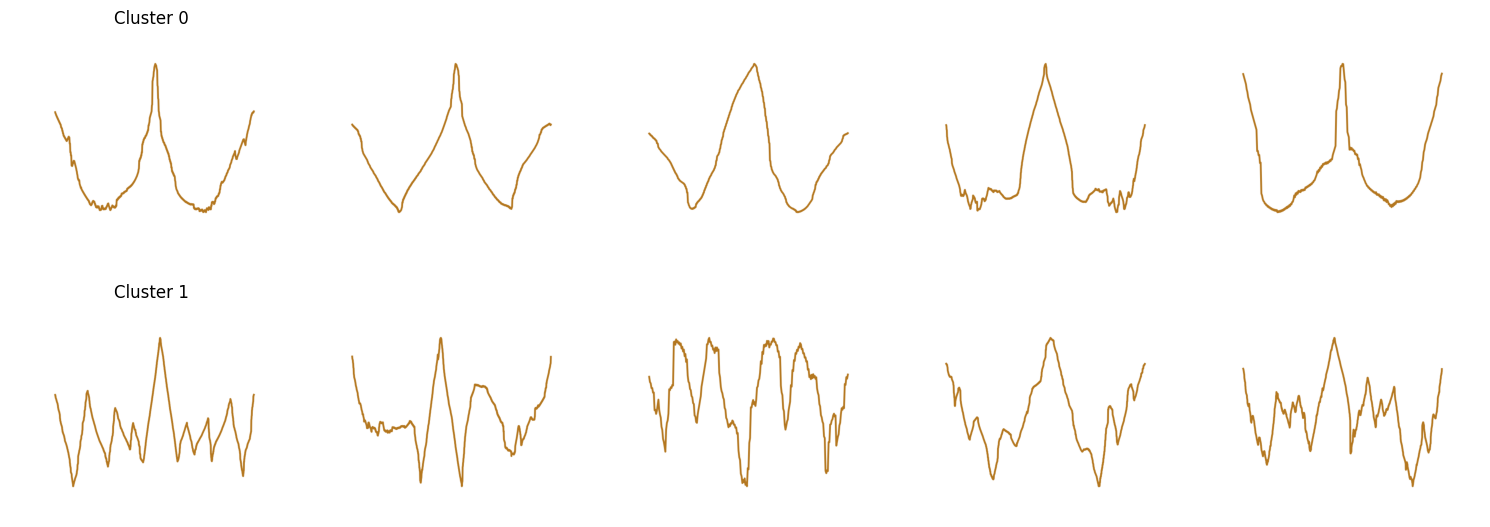

In [29]:
plot_five_ex_clusters(clusters , c_v2.rgb_images)

### apply_pca

In [65]:
pca_df = apply_pca(c_v2.list_images_hog , 'plot_hog' , n_components=1)
pca_df

,PC_plot_hog_1
0,-3.874641
1,-3.054783
2,-2.066479
3,0.496433
4,-4.115402
...,...
335,6.976740
336,6.562909
337,2.763158
338,4.712902


In [69]:
new_df = pd.read_csv('new_leaves.csv').drop(['Unnamed: 0'],axis=1)
new_df['2_cluster_hog_plot']= clusters
new_df = pd.concat([new_df , pca_df], axis=1)
new_df

,A,B,C,D,E,F,G,H,I,J,...,avg_leaf_to_background_ratio,num_petals_of_leaves,cnn_Kmeans_8_cluster,hog_Kmeans_2_cluster,cnn_Kmeans_4_cluster,cluster_on_distances,2_cluster_hog_plot,PC_dectances_from_centroid_1,PC_dectances_from_centroid_2,PC_plot_hog_1
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.835920,0.004657,0.003947,...,2.244901,2,5,1,1,1,0,-1.140975,-3.884069,-3.874641
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,...,2.066886,2,0,1,0,1,0,-6.435096,0.550471,-3.054783
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,...,1.882448,3,0,1,0,1,0,-7.907891,4.008734,-2.066479
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,...,1.938800,2,0,1,0,1,0,-6.613881,0.746459,0.496433
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,...,1.946505,2,0,1,0,1,0,-7.859157,4.059017,-4.115402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,36,6,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,...,0.956037,11,2,0,3,0,1,11.588817,9.259357,6.976740
336,36,7,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,...,1.088619,16,2,0,3,0,1,12.977147,9.204629,6.562909
337,36,8,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,...,0.501203,13,2,0,3,0,1,5.666209,6.460358,2.763158
338,36,9,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,...,0.406573,7,2,1,3,0,1,9.511234,5.380538,4.712902


In [71]:
new_df.to_csv('new_leaves.csv')

# Extract Features using a Pre-trained CNN in PyTorch

In [13]:
pytch = pythorch_images()
pytch.load_images("leaves_final/")
pytch.extract_features_cnn()
pytch.features.shape

c:\Users\akgh1\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\akgh1\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(340, 1000)

## kmean clustering

In [17]:
n_clusters = 8
clustering_model = KMeans(n_clusters=n_clusters, random_state=42)
clusters = clustering_model.fit_predict(pytch.features)
clusters

c:\Users\akgh1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([6, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 0,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 5, 5, 6, 5, 6, 6, 1, 1, 1, 1,
       5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 5, 3, 5, 3, 5,
       3, 0, 3, 5, 7, 7, 7, 3, 7, 7, 7, 7, 7, 7, 7, 5, 0, 0, 5, 5, 5, 5,
       0, 5, 5, 5, 0, 0, 5, 5, 5, 5, 0, 5, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 6, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 4, 6, 6, 0, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 6,
       2, 6, 3, 2, 2, 2, 2, 5, 5, 1, 5, 5, 5, 1, 5, 5, 5, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4, 0, 0, 0, 0,
       0, 6, 0, 4, 0, 0, 6, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 0,
       3, 3, 0, 4, 3, 3, 3, 3, 4, 0, 4, 4, 4, 0, 2, 0, 0, 2, 4, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5,
       5, 5, 1, 5, 1, 1, 1, 5, 1, 1, 3, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7,
       6, 4, 0, 4, 0, 0, 0, 4, 0, 4, 4, 0, 2, 0, 4,

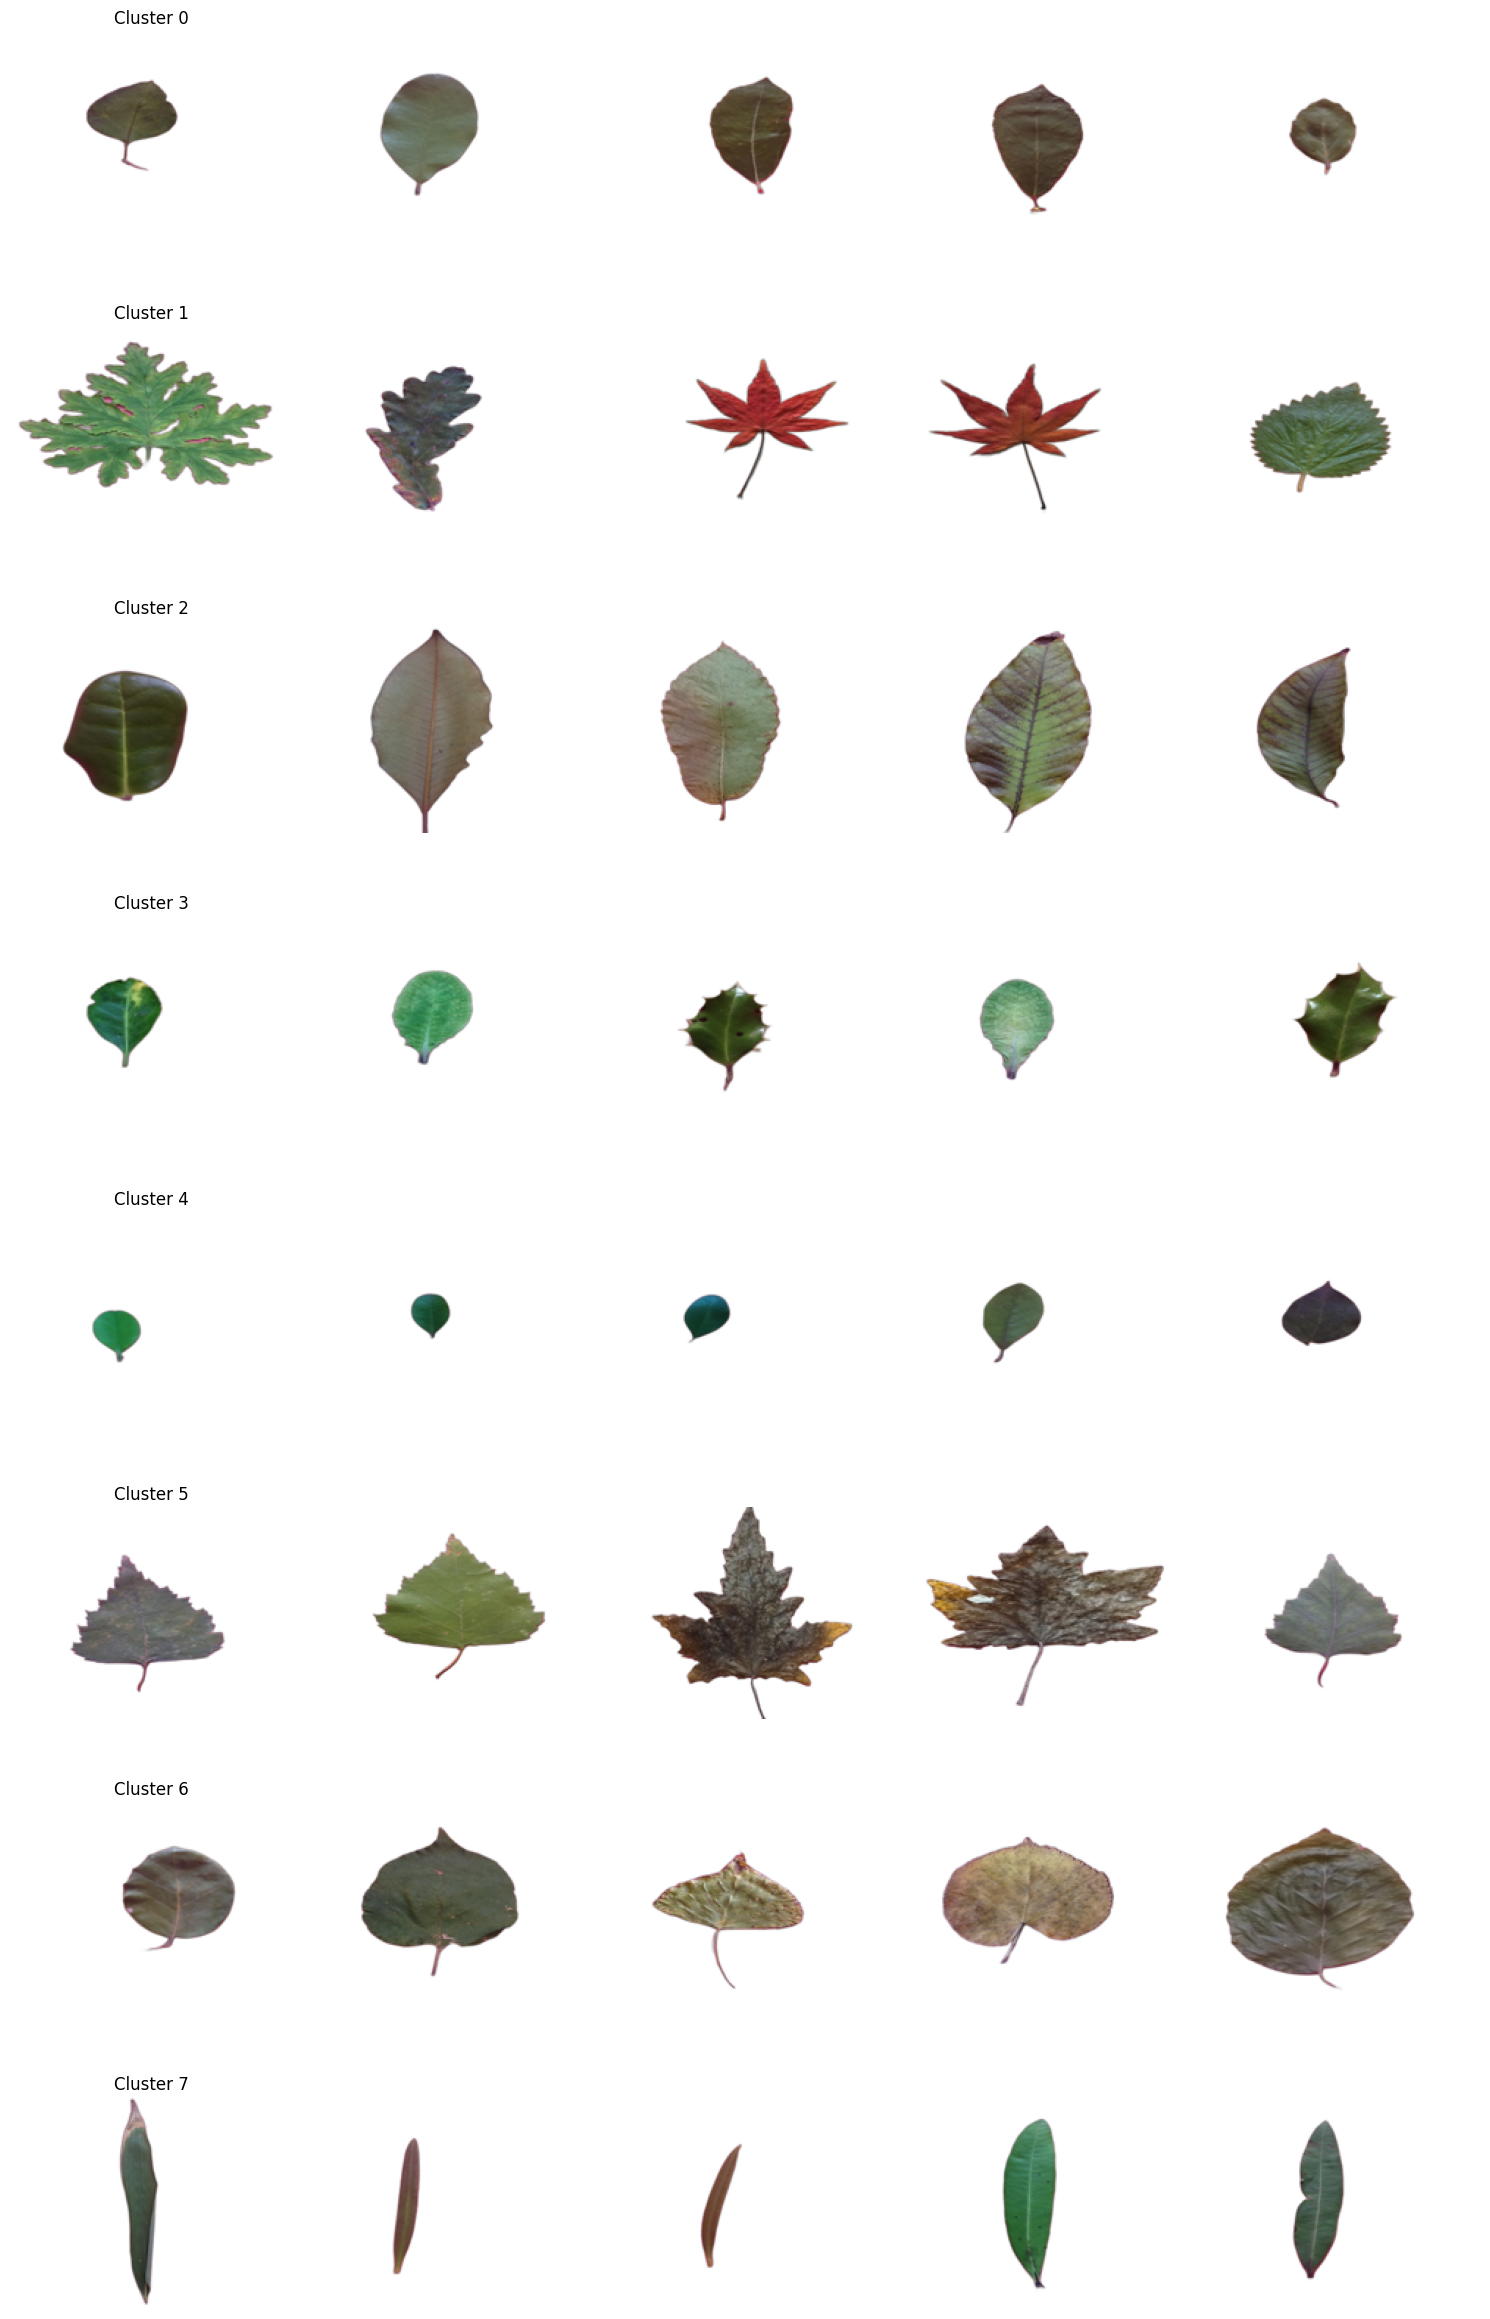

In [18]:
plot_five_ex_clusters(clusters , pytch.images)

## apply_PCA

In [14]:
pca_df = apply_pca(pytch.features,"cnn_features" , 2)
pca_df

,PC_cnn_features_1,PC_cnn_features_2
0,5.891276,3.404183
1,-0.386312,15.583080
2,-4.372416,25.726816
3,-6.802399,21.201992
4,-11.035375,24.993135
...,...,...
335,-30.436102,7.230901
336,-30.628275,4.702037
337,-27.708113,2.225046
338,-25.469162,8.524644


In [19]:
new_df = pd.read_csv('new_leaves.csv').drop(['Unnamed: 0'],axis=1)
# new_df['cnn_Kmeans_8_cluster']= clusters
new_df = pd.concat([new_df , pca_df], axis=1)
new_df

,A,B,C,D,E,F,G,H,I,J,...,cnn_Kmeans_4_cluster,cluster_on_distances,2_cluster_hog_plot,PC_dectances_from_centroid_1,PC_dectances_from_centroid_2,PC_plot_hog_1,PC_pictures_hog_1,PC_pictures_hog_2,PC_cnn_features_1,PC_cnn_features_2
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.835920,0.004657,0.003947,...,1,1,0,-1.140975,-3.884069,-3.874641,-0.594119,11.957644,5.891276,3.404183
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,...,0,1,0,-6.435096,0.550471,-3.054783,-5.462840,6.630552,-0.386312,15.583080
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,...,0,1,0,-7.907891,4.008734,-2.066479,-8.045611,3.459396,-4.372416,25.726816
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,...,0,1,0,-6.613881,0.746459,0.496433,-6.813601,4.748391,-6.802399,21.201992
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,...,0,1,0,-7.859157,4.059017,-4.115402,-9.762819,2.426338,-11.035375,24.993135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,36,6,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,...,3,0,1,11.588817,9.259357,6.976740,12.018704,2.145811,-30.436102,7.230901
336,36,7,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,...,3,0,1,12.977147,9.204629,6.562909,14.362893,3.853692,-30.628275,4.702037
337,36,8,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,...,3,0,1,5.666209,6.460358,2.763158,7.886197,1.708210,-27.708113,2.225046
338,36,9,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,...,3,0,1,9.511234,5.380538,4.712902,0.592375,-5.476900,-25.469162,8.524644


In [20]:
new_df.to_csv('new_leaves.csv')